# Implementing a Neural Network for CIFAR dataset
In this exercise, you should take the network from H.W_1 and change it to fit to this new dataset.

CIFAR is a dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model

Instead of loading a pre-trained model, we will guide you to define a new architecture.

## Loading CIFAR dataset

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 

You can use batch_size = 128

In [61]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy

transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 4
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# image_train = torch.utils.data.Subset(image_train, range(1,5000))
# image_val = torch.utils.data.Subset(image_val, range(1,500))

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=128,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=128,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


In [62]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1

In [87]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [96]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

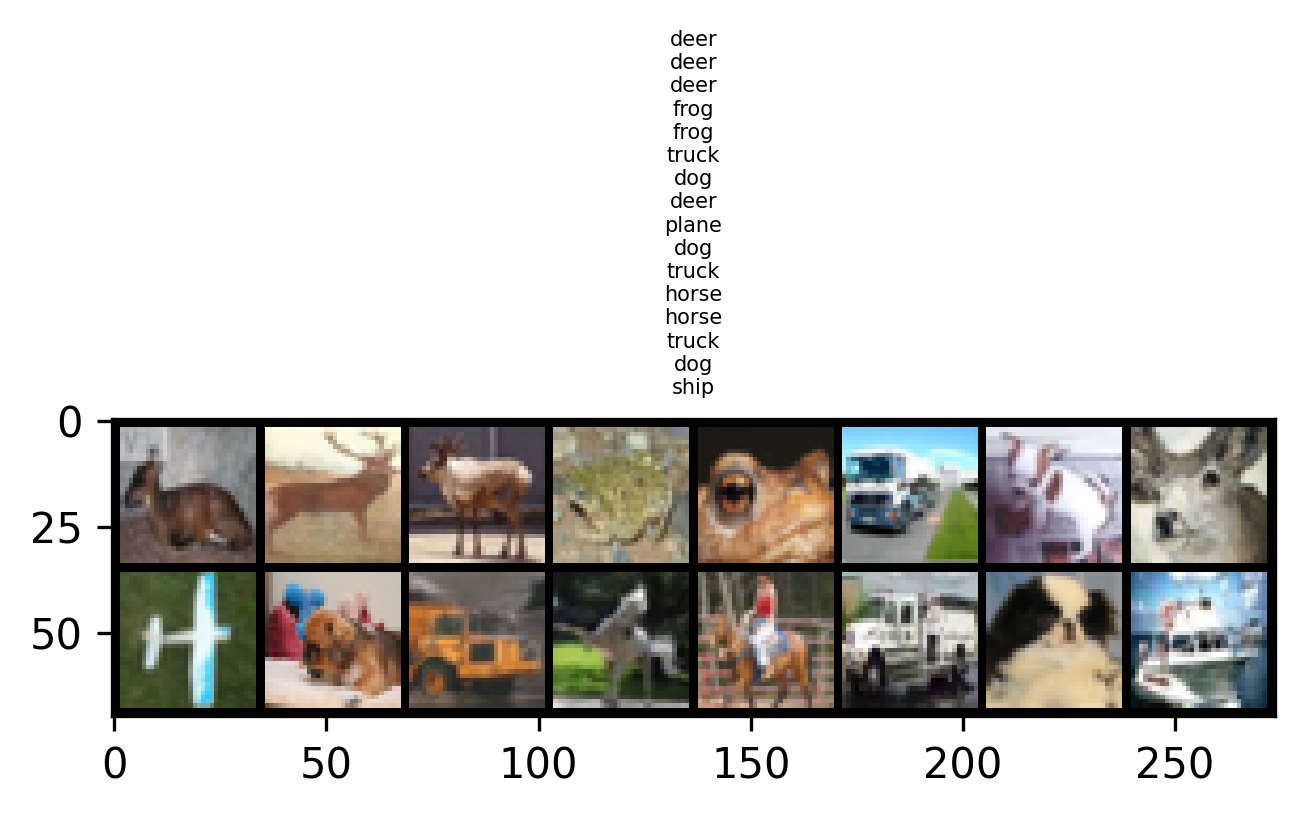

In [97]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

In [98]:
out.shape

torch.Size([3, 70, 274])

## A 2-layer Neural Network

We will define 2-layer network 

In [99]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        #School Solution
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(32*32*3, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 20),
        #     nn.ReLU(),
        #     nn.Linear(20, 10),
        # )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [113]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Pay attention, in case you change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**

**You should tun again the line** ``model = NeuralNetwork().to(device)``

In [114]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
### SCHOOL SOLUTION
optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [115]:
#TODO: add regularization? augmentation? 
# num_iters=1000, batch_size=200,
#             learning_rate=1e-4, learning_rate_decay=0.95,
#             reg=0.25, verbose=True)
#train for 25 pochd


In [116]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                inputs = inputs-torch.mean(inputs)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                ### SCHOOL SOLUTION
                l1 = 0
                for p in model.parameters():
                  l1 += torch.norm(p)
                running_loss += 0.05*l1
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [117]:
model = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.0480 Acc: 0.2807
val Loss: 1.8281 Acc: 0.3602

Epoch 1/9
----------
train Loss: 1.7331 Acc: 0.3893
val Loss: 1.6503 Acc: 0.4271

Epoch 2/9
----------
train Loss: 1.5994 Acc: 0.4403
val Loss: 1.5520 Acc: 0.4582

Epoch 3/9
----------
train Loss: 1.5106 Acc: 0.4730
val Loss: 1.4863 Acc: 0.4777

Epoch 4/9
----------
train Loss: 1.4397 Acc: 0.4965
val Loss: 1.4480 Acc: 0.4967

Epoch 5/9
----------
train Loss: 1.3785 Acc: 0.5199
val Loss: 1.3983 Acc: 0.5141

Epoch 6/9
----------
train Loss: 1.3224 Acc: 0.5415
val Loss: 1.3742 Acc: 0.5217

Epoch 7/9
----------
train Loss: 1.2480 Acc: 0.5706
val Loss: 1.3482 Acc: 0.5319

Epoch 8/9
----------
train Loss: 1.2358 Acc: 0.5748
val Loss: 1.3436 Acc: 0.5308

Epoch 9/9
----------
train Loss: 1.2282 Acc: 0.5772
val Loss: 1.3405 Acc: 0.5361

Training complete in 1m 47s
Best val Acc: 0.536100


# 1) Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. Write this visualization here.


# 2) Tune your hyperparameters

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:

#################################################################################
# TODO: Tune hyperparameters using the validation set.                          #
#                                                                               #
#                                                                               #
#################################################################################
# Your code
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:

*Your explanation:*